# MODNet 'matbench_jdft2d' benchmarking

Matbench v0.1 test dataset for predicting exfoliation energies from crystal structure (computed with the OptB88vdW and TBmBJ functionals). Adapted from the JARVIS DFT database. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset, get_all_dataset_info

from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [ ]:
info = get_all_dataset_info("matbench_steels")

## Data exploration

In [2]:
df = load_dataset("matbench_jdft2d")

In [3]:
df.columns

Index(['structure', 'exfoliation_en'], dtype='object')

### Target space

In [4]:
df.describe()

,exfoliation_en
count,636.000000
mean,112.698309
std,134.276663
min,0.026500
25%,58.811481
50%,79.803667
75%,101.289264
max,1604.038286


Text(0.5, 0, 'Exfoliation energy (meV)')

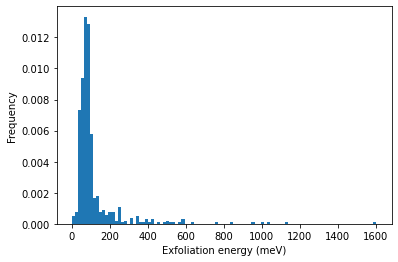

In [5]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["exfoliation_en"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("Exfoliation energy (meV)")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [13]:
PRECOMPUTED_MODDATA = "./precomputed/matbench_jdft2d.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_jdft2d")
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["exfoliation_en"].tolist(), 
        target_names=["Exfoliation energy (meV)"],
        featurizer=DeBreuck2020Featurizer(n_jobs=8)
    )
    data.featurize()
    data.save(PRECOMPUTED_MODDATA)

INFO:root:Loaded DeBreuck2020Featurizer featurizer.
INFO:root:Computing features, this can take time...
INFO:root:Applying composition featurizers...
INFO:root:Applying featurizers (AtomicOrbitals(), AtomicPackingEfficiency(), BandCenter(), ElementFraction(), ElementProperty(data_source=<matminer.utils.data.MagpieData object at 0x7fa8035d5910>,
                features=['Number', 'MendeleevNumber', 'AtomicWeight',
                          'MeltingT', 'Column', 'Row', 'CovalentRadius',
                          'Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
                          'GSvolume_pa', 'GSbandgap', 'GSmagmom',
                          'SpaceGroupNumber'],
                stats=['minimum', 'maximum', 'range', 'mean', 'avg_dev',
                       'mode']), IonProperty(), Miedema(ss_types=['min'], struct_types=['in

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  alp_a = (np.multiply(1.5, np.power(v_a, 2 / 3)) /
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  alp_a = (np.multiply(1.5, np.power(v_a, 2 / 3)) /
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  alp_a = (np.multiply(1.5, np.power(v_a, 2 / 3)) /
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  alp_a = (np.multiply(1.5, np.power(v_a, 2 / 3)) /
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  alp_a = (np.multiply(1.5, np.power(v_a, 2 / 3)) /
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  alp_a = (np.multiply(1.5, np.power(v_a, 2 / 3)) /
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  alp_a = (np.multiply(1.5, np.power(v_a, 2 / 3)) /
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  alp_a = (np.multiply(1.5, np.power(v_a, 2 / 3)) /
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/composition.py:1357: RuntimeWarning: invalid value encountered in power
  

INFO:root:Applying featurizers (ElectronegativityDiff(stats=['minimum', 'maximum', 'range', 'mean', 'std_dev']), OxidationStates(stats=['minimum', 'maximum', 'range', 'std_dev'])) to column 'composition_oxid'.


INFO:root:Applying structure featurizers...
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
INFO:root:Applying featurizers (DensityFeatures(), GlobalSymmetryFeatures(), RadialDistributionFunction(), CoulombMatrix(), SineCoulombMatrix(), EwaldEnergy(), BondFractions(), StructuralHeterogeneity(), MaximumPackingEfficiency(), ChemicalOrdering(), XRDPowderPattern(pattern_length=128)) to column 'structure'.


/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4302: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4085: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4302: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4085: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/home/

INFO:root:Applying site featurizers...


/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/site.py:2383: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/site.py:2383: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/site.py:2383: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/site.py:2383: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers/site.py:2383: RuntimeWarning: invalid value encountered in arccos
  if np.isnan(np.arccos(dot)):
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/matminer/featurizers

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4302: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4085: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4302: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4302: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/modl/mevans/.cond

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4302: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4085: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4302: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:4085: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/home/

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sites = np.array(sites)[uniq_inds]
/home/modl/mevans/.conda/envs/modnet/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:805: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

INFO:root:Data has successfully been featurized!
INFO:root:Data successfully saved as ./precomputed/matbench_jdft2d.pkl.gz!


In [18]:
data.save(PRECOMPUTED_MODDATA)

INFO:root:Data successfully saved as ./precomputed/matbench_jdft2d.pkl.gz!


In [17]:
data.feature_selection(n=650)

INFO:root:Starting target 1/1: Exfoliation energy (meV) ...
INFO:root:Computing mutual information between features and target...
INFO:root:Computing optimal features...
INFO:root:Selected 50/650 features...
INFO:root:Selected 100/650 features...
INFO:root:Selected 150/650 features...
INFO:root:Selected 200/650 features...
INFO:root:Selected 250/650 features...
INFO:root:Selected 300/650 features...
INFO:root:Selected 350/650 features...
INFO:root:Selected 400/650 features...
INFO:root:Selected 450/650 features...
INFO:root:Selected 500/650 features...
INFO:root:Selected 550/650 features...
INFO:root:Selected 600/650 features...
INFO:root:Done with target 1/636: Exfoliation energy (meV).
INFO:root:Merging all features...
INFO:root:Done.


In [19]:
bs = 64
lr = 0.01
archs = [
    (64, [[64], [8], [8], []]),
    (64, [[64], [32], [8], [8]]),
    (64, [[128], [64], [32], [8]]),
    (128, [[128], [64], [32], [8]]),
]

epochs = 5000
loss = "mse"
act = "elu"

presets = [dict(batch_size=bs, lr=lr, epochs=epochs, loss=loss, act=act, n_feat=a[0], num_neurons=a[1]) for a in archs]

In [ ]:
data.df_targets.rename(columns={data.target_names[0]: "E"}, inplace=True)

model = MODNetModel(
    [[["E"]]], 
    {"E": 1}, 
)

model.fit_preset(data, presets, val_fraction=0.2)

INFO:root:Training preset #1/4
INFO:root:Compiling model...
INFO:root:Fitting model...


,Exfoliation energy (meV)
id0,63.593833
id1,134.863750
id2,43.114667
id3,240.715488
id4,67.442833
...,...
id631,26.426545
id632,43.574286
id633,88.808659
id634,132.265250
